We use the example container `648377366` where the mouse runs fast, and have good representations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap


from sklearn import datasets, linear_model
from scipy.stats import linregress

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info

import pprint

In [2]:
# import our own functions
import rep_drift, visualize_drift

In [3]:
boc = BrainObservatoryCache()

In [4]:
# use one example container:
data_sets, ordered_days = rep_drift.get_datasets(boc, 648377366) 


In [5]:
def plot_2D(Xt, label):
    plt.figure(figsize=(8,6.5))
    plt.scatter(Xt[:,0], Xt[:,1], c= label)
    plt.colorbar()
    plt.show() 

def plot_3D(Xt, label):
    fig = plt.figure(figsize = [8,8])
    ax = fig.add_subplot(projection='3d')
    ax.scatter(Xt[:,0], Xt[:,1], Xt[:,2], c= label)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

-------

### All three experiments:

In [6]:
# get response vectors of all three sessions, align the shared neurons:
dff_vals_container, run_vals_container = rep_drift.align_response_vals(data_sets)

In [7]:
n_sessions = 3
n_repeats = 10
dff_vals_all = np.zeros((30, 30, dff_vals_container[0].shape[-1]))

for session_idx in range(n_sessions):
    dff_vals_all[session_idx*n_repeats:session_idx*n_repeats+n_repeats] = dff_vals_container[session_idx]

In [8]:
def calc_similarity(dff_vals):
    
    n_repeats = 30 # 10*3
    n_divs = 30 

    within_session_corrs = np.zeros((n_repeats*n_divs, n_repeats*n_divs))
    within_session_angles = np.zeros((n_repeats*n_divs, n_repeats*n_divs))

    for repeat_idx1 in range(n_repeats):
        for repeat_idx2 in range(n_repeats):
            # corrcoef for all blocks in repeat_1 and repeat_2:
            within_session_corrs[ 
                repeat_idx1*n_divs : (repeat_idx1+1)*n_divs, 
                repeat_idx2*n_divs : (repeat_idx2+1)*n_divs] = np.corrcoef(
                    # return 30x30 R-values:
                    dff_vals[repeat_idx1], dff_vals[repeat_idx2])[n_divs:, :n_divs] # for some reason corrcoef returns 4 copies of this matrix
            
            for div_idx1 in range(n_divs):
                for div_idx2 in range(n_divs):
                    # calculate angle 
                    # for resp_vec of block_1 in repeat_1 and
                    #  resp_vec in block_2 in repeat_2:
                    within_session_angles[
                        repeat_idx1 * n_divs + div_idx1, 
                        repeat_idx2 * n_divs + div_idx2] = rep_drift.get_align_angle(
                            dff_vals[repeat_idx1, div_idx1], 
                            dff_vals[repeat_idx2, div_idx2])

    return within_session_corrs, within_session_angles

In [10]:
corrs_all, angles_all = calc_similarity(dff_vals_all)

In [11]:
label_stimuli_all = list(range(30))*30
label_eye_ball = ([0]*6 + [1]*5 + [2]*3 + [3]*2 + [4]*6 + [5]*4 + [6]*4) * 30 # my own seven bins segmentation

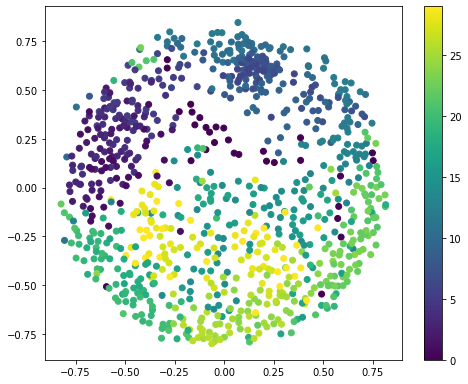

In [12]:
nmds_all = MDS(random_state= 1693, dissimilarity='precomputed')
Xt_mds_all =  nmds_all.fit_transform(1- corrs_all)
plot_2D(Xt_mds_all, label = label_stimuli_all)

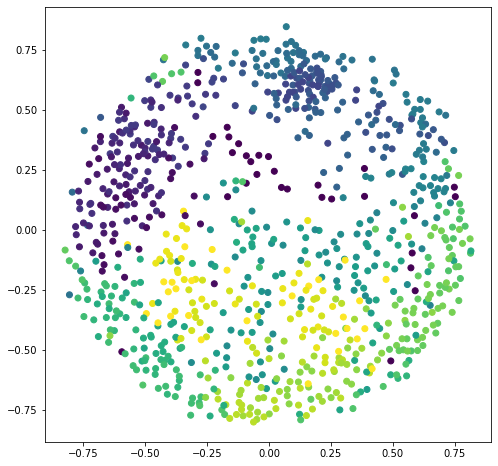

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(Xt_mds_all[:,0], Xt_mds_all[:,1], c= label_stimuli_all)
plt.show() 
fig.savefig('nMDS-1.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(Xt_mds_all[:,0], Xt_mds_all[:,1], c= label_stimuli_all)
plt.show() 
fig.savefig('nMDS-1.pdf')

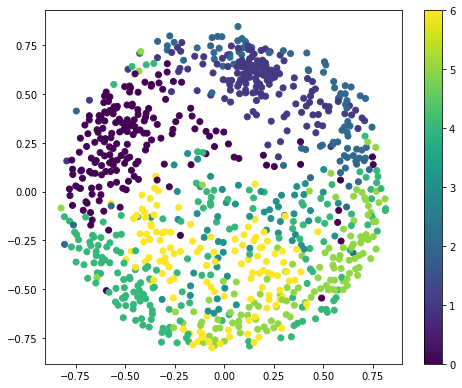

In [13]:
plot_2D(Xt_mds_all, label = label_eye_ball)

In [18]:
Xt_mds_df = pd.DataFrame(Xt_mds_all, columns = ['x1', 'x2'])
Xt_mds_df['second'] = label_stimuli_all
second_means = Xt_mds_df.groupby('second', as_index=False)['x1', 'x2'].mean()
second_means_arr = second_means.loc[:, ['x1', 'x2']].to_numpy()

/Users/xinzheng/opt/anaconda3/envs/rep-drift/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
def calc_mean_traj(Xt_mds, label_stimuli):
    
    Xt_mds_df = pd.DataFrame(Xt_mds, columns = ['x1', 'x2'])
    Xt_mds_df['second'] = label_stimuli
    second_means = Xt_mds_df.groupby('second', as_index=False)['x1', 'x2'].mean()
    second_means_arr = second_means.loc[:, ['x1', 'x2']].to_numpy()

    return second_means_arr

In [21]:
second_means_arr_1 = calc_mean_traj(Xt_mds_all[:300], label_stimuli_all[:300])
second_means_arr_2 = calc_mean_traj(Xt_mds_all[300:600], label_stimuli_all[300:600])
second_means_arr_3 = calc_mean_traj(Xt_mds_all[600:900], label_stimuli_all[600:900])

/Users/xinzheng/opt/anaconda3/envs/rep-drift/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [29]:
def plot_trajectory(means_arr, lw = 2):
    colors = plt.cm.viridis(np.linspace(0, 1, 29))
    for i in range(29):
        line = np.array([means_arr[i], means_arr[i+1]])
        ax.plot(line[:, 0], line[:, 1], color = colors[i], linestyle = 'dashed', lw = lw)

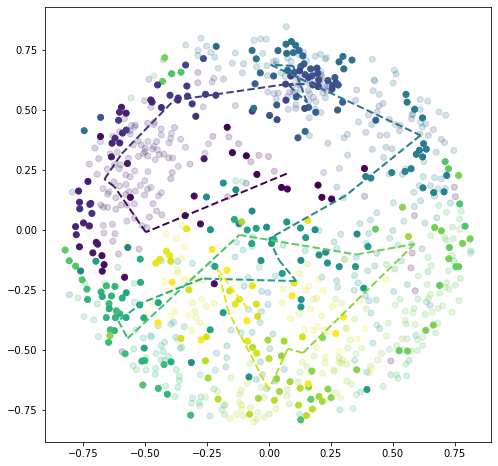

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(Xt_mds_all[:,0], Xt_mds_all[:,1], c= label_stimuli_all, alpha = .2)
ax.scatter(Xt_mds_all[600:900,0], Xt_mds_all[600:900,1], c= label_stimuli_all[600:900])
plot_trajectory(second_means_arr_3)
plt.show() 
# fig.savefig('nMDS-3.pdf')

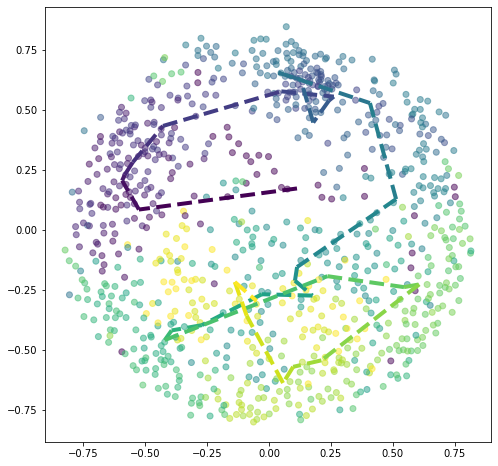

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(Xt_mds_all[:,0], Xt_mds_all[:,1], c= label_stimuli_all, alpha = .5)
plot_trajectory(second_means_arr, lw = 4)
plt.show() 
fig.savefig('nMDS-4.pdf')

In [35]:
pca_all = PCA()
Xt_pca_all =  pca_all.fit_transform(1- corrs_all)

In [38]:
rep_drift.effective_dimention(pca_all.explained_variance_ratio_)

16.603388546816976

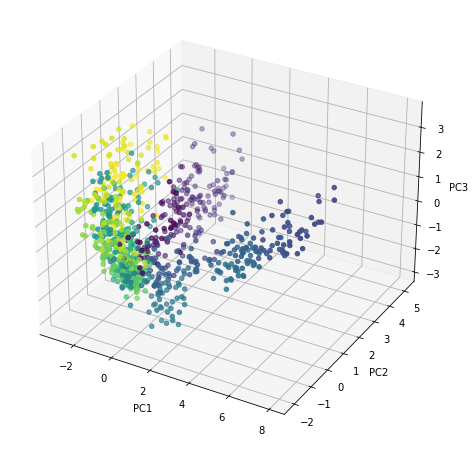

In [42]:
fig = plt.figure(figsize = [8,8])
ax = fig.add_subplot(projection='3d')
ax.scatter(Xt_pca_all[:,0], Xt_pca_all[:,1], Xt_pca_all[:,2], c= label_stimuli_all)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.savefig('PCA-0.pdf')

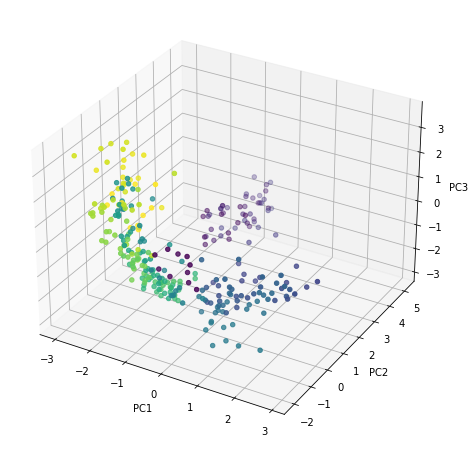

In [55]:
fig = plt.figure(figsize = [8,8])
ax = fig.add_subplot(projection='3d')
# ax.scatter(Xt_pca_all[:,0], Xt_pca_all[:,1], Xt_pca_all[:,2], c= label_stimuli_all, alpha = .01)
ax.scatter(Xt_pca_all[300:600,0], Xt_pca_all[300:600,1], Xt_pca_all[300:600,2], c=  label_stimuli_all[300:600])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
# fig.savefig('PCA-2.pdf')



In [56]:
# calculate cross session similarities over the mean resp. vectors:
across_session_corrs, across_session_angles =  rep_drift.calc_cross_similarity(dff_vals_container)

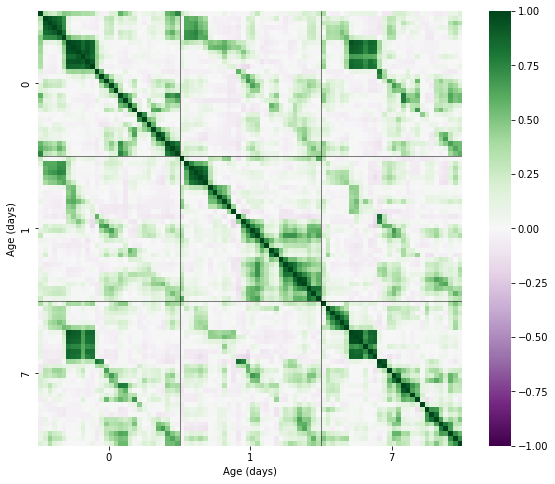

In [57]:
# plot cross session:
visualize_drift.plot_cross_corr(across_session_corrs, ordered_days)

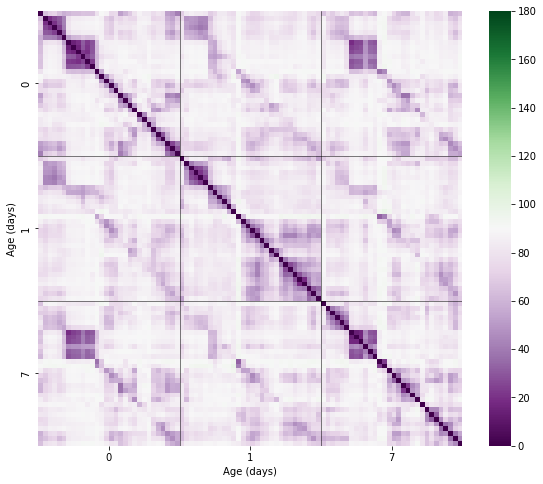

In [59]:
visualize_drift.plot_cross_angle(across_session_angles, ordered_days)